Let's import some packages

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
from astropy import units as u
from scipy.optimize import minimize
from scipy.stats import linregress
print astropy.__version__
import math
import emcee
import corner
import pandas as pd

import matplotlib 
%matplotlib notebook

from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

import winsound

import time

winsound.Beep(440,1500)

2.0.2


And write some classes. An arcoiris_merged_spectrum object is exactly what it says it is. An arcoiris_spectrum is the unmerged data, comprising multiple spectral_order objects. A spex_spectrum object is what it says it is. So's a continuum_spectrum object.

Because the SpeX spectra come in $\mathrm{W m^{-2} \mu m^{-1}}$ and the ARCoIRIS spectra are in $\mathrm{erg s^{-1} cm^{-2} angstrom^{-1}}$, I store the science objects in both units (different by a factor of 10, per dimensional analysis). For easier management, I created the high_snr_spectrum and high_snr_spectrum_watts classes to more easily store the hi-res components of these.

In [2]:
class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}

class arcoiris_merged_spectrum(object):
    def __init__(self, name, data, date):
        self.objectname = name
        self.obsdate = date
        
        tempwav = []
        tempflux = []
        temperr = []
        #tempsnr = []
        
        for line in data:
            conts = line.split()
            tempwav.append(float(conts[0]))
            tempflux.append(float(conts[1]))
            temperr.append(float(conts[2]))
            
        self.wav = np.array(tempwav)
        self.flux = np.array(tempflux)
        self.err = np.array(temperr)
        self.snr = self.flux/self.err
        
        self.flux_watts = self.flux*10.
        self.err_watts = self.err*10.
        
    def __str__(self):
        s = 'Wav Flux Err \n'
        for i in range(self.wav.size):
            s = s + str(self.wav[i]) + ' ' + str(self.flux[i]) + ' ' + str(self.err[i]) + '\n'
            
        return s
        
        
class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return
    
class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig

class continuum_spectrum(object):
    def __init__(self, data, is_normalized):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        wavelength_list = []
        flux_density_list = []
        #full_error_list = []        
        #short_wavelength_list = []
        #short_flux_density_list = []
        #short_error_list = []
        #long_wavelength_list = []
        #long_flux_density_list = []
        #long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            #error = float(comps[2])
        
            #if (wav < -900.) or (flux < -900.) or (error < -900.):
            #    continue

            wavelength_list.append(float(comps[0]))
            flux_density_list.append(float(comps[1]))
            #full_error_list.append(float(comps[2]))
            
            #if wav < 2.75:
            #    short_wavelength_list.append(float(comps[0]))
            #    short_flux_density_list.append(float(comps[1]))
            #    short_error_list.append(float(comps[2]))
            #else:
            #    long_wavelength_list.append(float(comps[0]))
            #    long_flux_density_list.append(float(comps[1]))
            #    long_error_list.append(float(comps[2]))                
        
        self.wavelength = np.array(wavelength_list)
        self.flux_density = np.array(flux_density_list)
        self.is_normalized = is_normalized
        #self.full_error = np.array(full_error_list)
        
        #self.short_wavelength = np.array(short_wavelength_list)
        #self.short_flux_density = np.array(short_flux_density_list)
        #self.short_error = np.array(short_error_list)
        #self.long_wavelength = np.array(long_wavelength_list)
        #self.long_flux_density = np.array(long_flux_density_list)
        #self.long_error = np.array(long_error_list)
    
        return
    
class high_snr_spectrum(object):
    def __init__(self,input_spectrum,snrthreshold):
        self.wav = np.array([input_spectrum.wav[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.flux = np.array([input_spectrum.flux[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.err = np.array([input_spectrum.err[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        
        return
        
class high_snr_watts_spectrum(object):
    def __init__(self,input_spectrum,snrthreshold):
        self.wav = np.array([input_spectrum.wav[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.flux_watts = np.array([input_spectrum.flux_watts[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        self.err_watts = np.array([input_spectrum.err_watts[i] for i in range(input_spectrum.wav.size) if input_spectrum.snr[i] > snrthreshold])
        
        return

Some functions for reading spectra in from text files.

In [3]:
def import_arcoiris_from_text(filename, name, date):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_merged_spectrum(name, data, date)
    
    return spectrum

def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum

def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum

def import_continuum_spectrum_from_file(filename,is_normalized):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = continuum_spectrum(data,is_normalized)
    return spectrum

Functions for generating the highsnr spectra from the read-in text file spectra.

In [4]:
def get_snr_cut_spectrum(spectrum,snrthreshold):
        
    cut_spectrum = high_snr_spectrum(spectrum,snrthreshold)        
    return cut_spectrum
    
def get_snr_cut_spectrum_watts(spectrum,snrthreshold):
        
    cut_spectrum = high_snr_watts_spectrum(spectrum,snrthreshold)        
    return cut_spectrum

Read in spectra.

In [5]:
awi0005x3s_20171104_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_remerged.txt','AWI0005x3s','2017-11-04')
awi0005x3s_20180301_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180301_remerged.txt','AWI0005x3s','2018-03-01')
awi0005x3s_20180302_remerged = import_arcoiris_from_text('awi0005x3s_xtc_20180302_remerged.txt','AWI0005x3s','2018-03-02')

awi0005x3s_20171104_2massweighted_merged = import_arcoiris_from_text('awi0005x3s_xtc_20171104_2massweighted_merged.txt','AWI0005x3s','2017-11-04')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

First row found: 47


Get high SNR spectra.

In [6]:
awi0005x3s_20171104_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20171104_remerged,20.)
awi0005x3s_20180301_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20180301_remerged,20.)
awi0005x3s_20180302_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20180302_remerged,20.)

awi0005x3s_20171104_2mass_highsnr = get_snr_cut_spectrum_watts(awi0005x3s_20171104_2massweighted_merged,20.)


Fun with plotting.

<IPython.core.display.Javascript object>


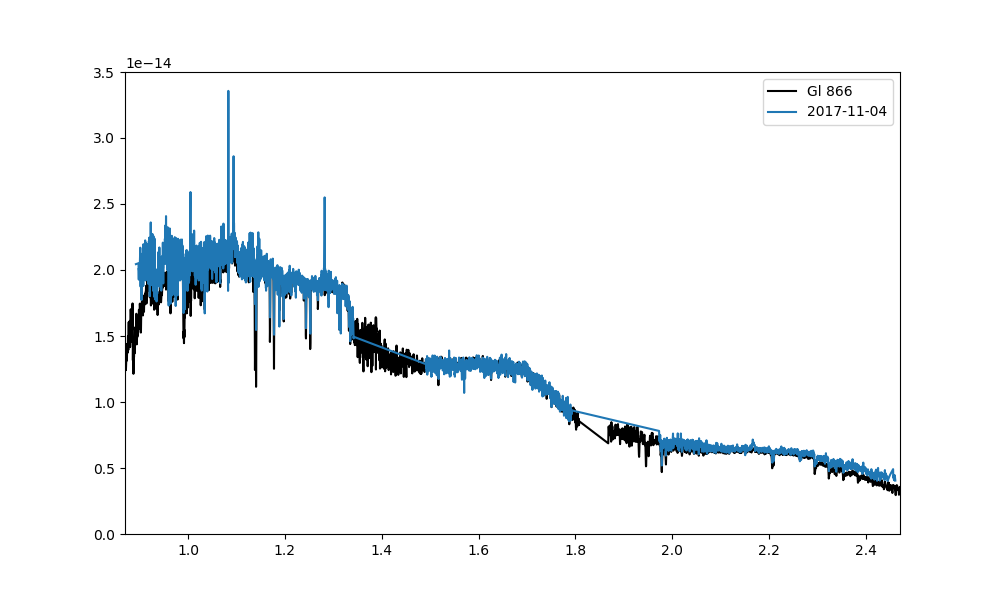

<IPython.core.display.Javascript object>


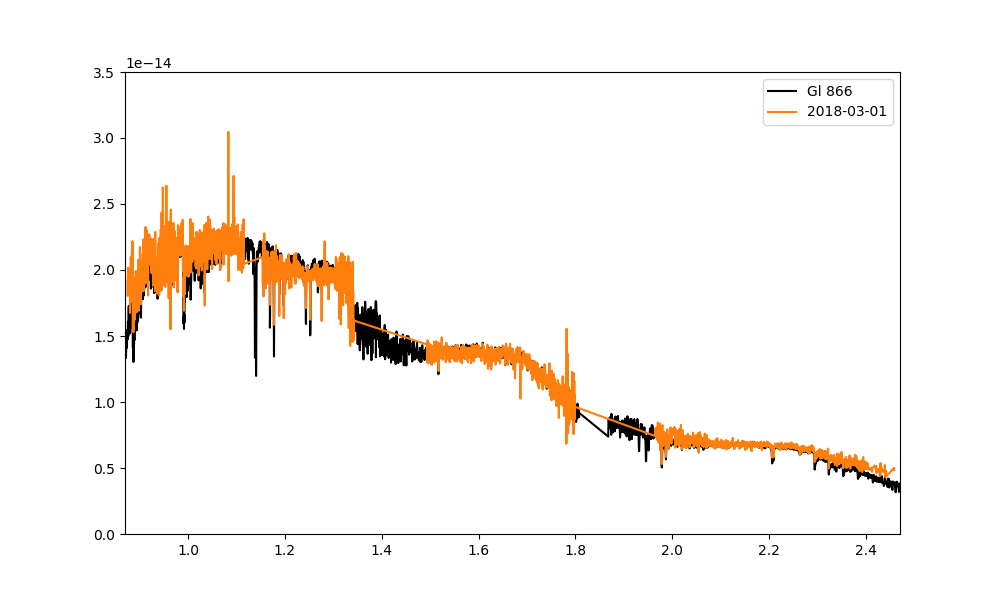

<IPython.core.display.Javascript object>


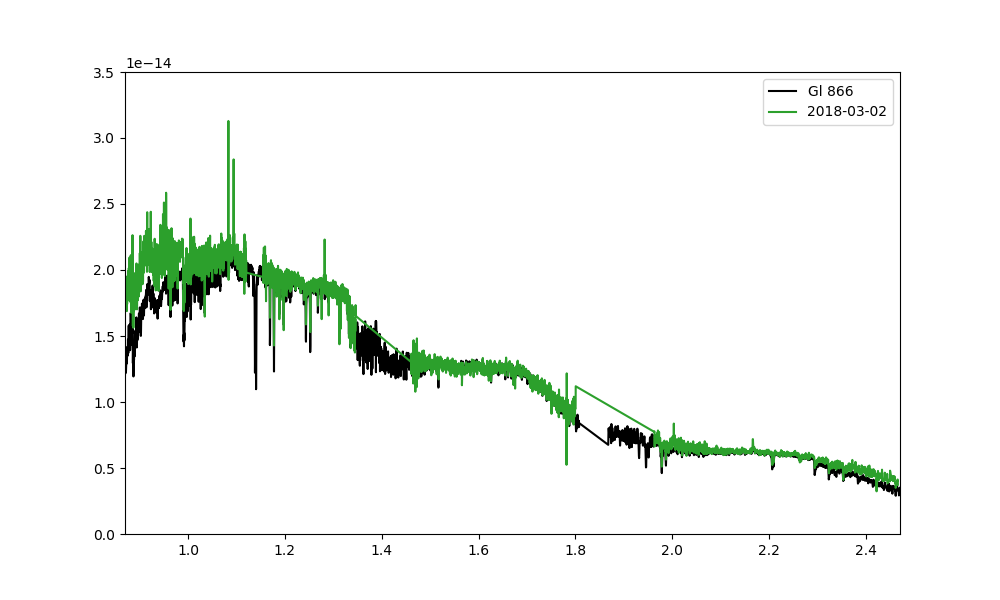

<IPython.core.display.Javascript object>


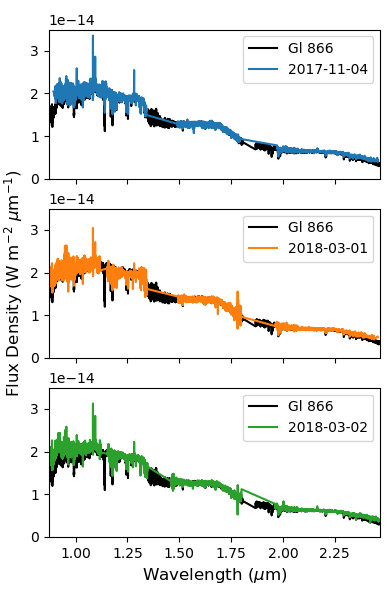

In [7]:
plt.close('all')

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
plt.xlim([0.87,2.47])
plt.ylim([0.,3.5e-14])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/380.,'k',label='Gl 866')
plt.plot([0., 1.], [0., 1.])
plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
plt.xlim([0.87,2.47])
plt.ylim([0.,3.5e-14])
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10.,6.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/415.,'k',label='Gl 866')
plt.plot([0., 1.], [0., 1.])
plt.plot([0., 1.], [0., 1.])
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
plt.xlim([0.87,2.47])
plt.ylim([0.,3.5e-14])
plt.legend(loc='upper right')
plt.show()

wav_20171104_angstroms = awi0005x3s_20171104_highsnr.wav*10000.
wav_20180301_angstroms = awi0005x3s_20180301_highsnr.wav*10000.
wav_20180302_angstroms = awi0005x3s_20180302_highsnr.wav*10000.

wav_20171104_2mass_angstroms = awi0005x3s_20171104_2mass_highsnr.wav*10000.

#bb_20171104 = blackbody_lambda(wav_20171104_angstroms * u.AA, 1071.) #* np.pi * u.sr * u.cm * u.cm * u.s / u.erg * wav_20171104_angstroms * u.AA / awi0005x3s_20171104_remerged.wav

#print max(bb_20171104)

#print max(bb_20171104*0.11)

#plt.plot(awi0005x3s_20171104_highsnr_wav, bb_20171104*0.11)

#plt.xlim([0.87,2.47])
#plt.ylim([0.,1.5e-11])

#plt.legend(loc='upper right')

#plt.show()

f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(3.9,5.9))
axarr[0].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
axarr[0].set_ylim([0.,3.5e-14])
axarr[0].legend(loc='upper right')
#axarr[0].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=10)

axarr[1].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/380.,'k',label='Gl 866')
axarr[1].plot([0., 1.], [0., 1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
axarr[1].set_ylim([0.,3.5e-14])
axarr[1].legend(loc='upper right')
axarr[1].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)

axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/415.,'k',label='Gl 866')
axarr[2].plot([0., 1.], [0., 1.])
axarr[2].plot([0., 1.], [0., 1.])
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
axarr[2].legend(loc='upper right')
#axarr[2].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=10)
axarr[2].set_xlim([0.87, 2.47])
axarr[2].set_ylim([0.,3.5e-14])
axarr[2].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)

f.subplots_adjust(hspace=0.2)
f.subplots_adjust(right=0.975)
f.subplots_adjust(top=0.95)
f.subplots_adjust(bottom=0.09)
f.savefig('AWI0005x3s_full_highsnr_spectra.pdf')



Some material for estimating the brightness of the K-band excess.

In [8]:
#awi0005x3s_20171104_remerged_wav_angstroms = awi0005x3s_20171104_remerged.wav * 10000.

#stellar radius in meters
rstar = 0.30 * 695700000.

#distance from trig. parallax, in meters
dstar = (1000./9.8599) * 3.08567758149137e16

rdstar = (rstar**2)/(dstar**2)

print rdstar

Tdisk = 1071.
Tstar = 3050.

Tratio = (Tdisk/Tstar)**4

print Tratio

max_xdisk = 0.11 / Tratio * rdstar

print max_xdisk

bestfit_xdisk = 0.054 / Tratio * rdstar

print bestfit_xdisk

test_xdisk = 0.10 /Tratio * rdstar

template_wav_angstroms = template_spectrum.short_wavelength * 10000.

awi0005x3s_20171104_2mass_merged_blackbody = blackbody_lambda(wav_20171104_2mass_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20171104_2mass_angstroms_trunclong = np.array([x for x in wav_20171104_2mass_angstroms if x > (2.285e4)])
awi0005x3s_20171104_2mass_merged_blackbody_trunclong = blackbody_lambda(wav_20171104_2mass_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict = {wav_20171104_2mass_angstroms_trunclong[i]: awi0005x3s_20171104_2mass_merged_blackbody_trunclong[i] for i in range(awi0005x3s_20171104_2mass_merged_blackbody_trunclong.size)}

awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting = np.zeros(wav_20171104_2mass_angstroms.size)
for i in range(wav_20171104_2mass_angstroms.size):
    if wav_20171104_2mass_angstroms[i] > 2.285e4:
        awi0005x3s_20171104_2mass_merged_blackbody_trunclong_plotting[i] = awi0005x3s_20171104_2mass_merged_blackbody_trunclong_dict[wav_20171104_2mass_angstroms[i]]

template_wav_angstroms_trunclong = np.array([x for x in template_wav_angstroms if x > (2.285e4)])
template_blackbody_trunclong = blackbody_lambda(template_wav_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

template_blackbody_trunclong_dict = {template_wav_angstroms_trunclong[i]: template_blackbody_trunclong[i] for i in range(template_blackbody_trunclong.size)}

template_blackbody_trunclong_plotting = np.zeros(template_wav_angstroms.size)
for i in range(template_wav_angstroms.size):
    if template_wav_angstroms[i] > 2.285e4:
        template_blackbody_trunclong_plotting[i] = template_blackbody_trunclong_dict[template_wav_angstroms[i]]


print max(awi0005x3s_20171104_2mass_merged_blackbody)

4.44764838653e-21
0.015204023281
3.21784118241e-20
1.57966748955e-20
5.18550045273e-16


More K-band excess stuff.

In [9]:
test_xdisk_20180301 = 0.11 / Tratio * rdstar

awi0005x3s_20180301_blackbody = blackbody_lambda(wav_20180301_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180301_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180301 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180301_angstroms_trunclong = np.array([x for x in wav_20180301_angstroms if x > (2.285e4)])
awi0005x3s_20180301_blackbody_trunclong = blackbody_lambda(wav_20180301_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180301_blackbody_trunclong_dict = {wav_20180301_angstroms_trunclong[i]: awi0005x3s_20180301_blackbody_trunclong[i] for i in range(awi0005x3s_20180301_blackbody_trunclong.size)}

awi0005x3s_20180301_blackbody_trunclong_plotting = np.zeros(wav_20180301_angstroms.size)
for i in range(wav_20180301_angstroms.size):
    if wav_20180301_angstroms[i] > 2.285e4:
        awi0005x3s_20180301_blackbody_trunclong_plotting[i] = awi0005x3s_20180301_blackbody_trunclong_dict[wav_20180301_angstroms[i]]

Even more K-band excess stuff.

In [10]:
test_xdisk_20180302 = 0.09 / Tratio * rdstar

awi0005x3s_20180302_blackbody = blackbody_lambda(wav_20180302_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg
template_20180302_blackbody = blackbody_lambda(template_wav_angstroms, Tdisk) * np.pi * u.sr * test_xdisk_20180302 * 10. * u.AA * u.s * u.cm * u.cm / u.erg

wav_20180302_angstroms_trunclong = np.array([x for x in wav_20180302_angstroms if x > (2.285e4)])
awi0005x3s_20180302_blackbody_trunclong = blackbody_lambda(wav_20180302_angstroms_trunclong, Tdisk) * np.pi * u.sr * test_xdisk * 10. * u.AA * u.s * u.cm * u.cm / u.erg

awi0005x3s_20180302_blackbody_trunclong_dict = {wav_20180302_angstroms_trunclong[i]: awi0005x3s_20180302_blackbody_trunclong[i] for i in range(awi0005x3s_20180302_blackbody_trunclong.size)}

awi0005x3s_20180302_blackbody_trunclong_plotting = np.zeros(wav_20180302_angstroms.size)
for i in range(wav_20180302_angstroms.size):
    if wav_20180302_angstroms[i] > 2.285e4:
        awi0005x3s_20180302_blackbody_trunclong_plotting[i] = awi0005x3s_20180302_blackbody_trunclong_dict[wav_20180302_angstroms[i]]

<IPython.core.display.Javascript object>


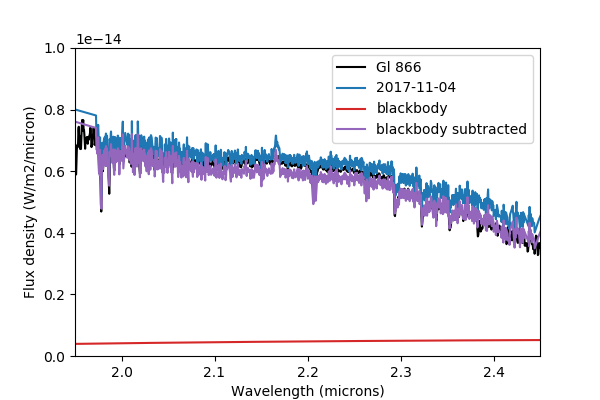

<IPython.core.display.Javascript object>


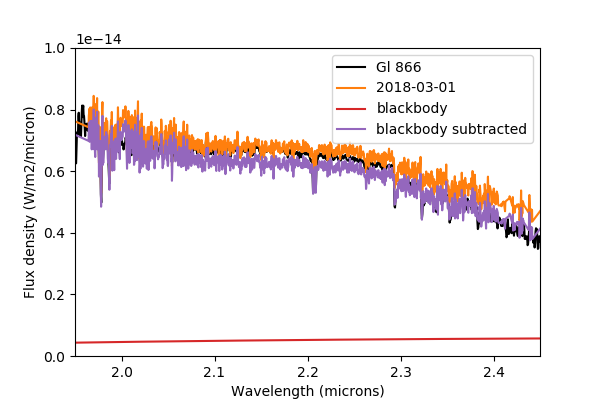

<IPython.core.display.Javascript object>


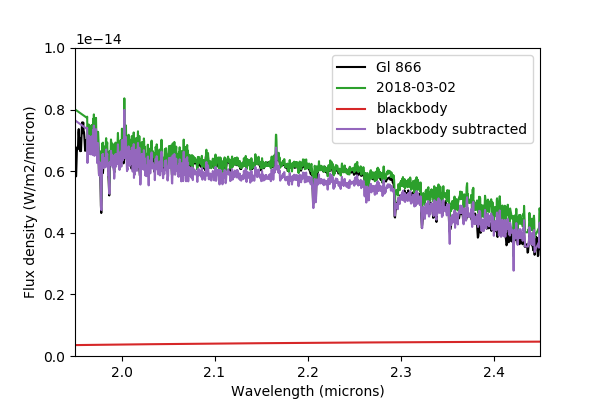

<IPython.core.display.Javascript object>


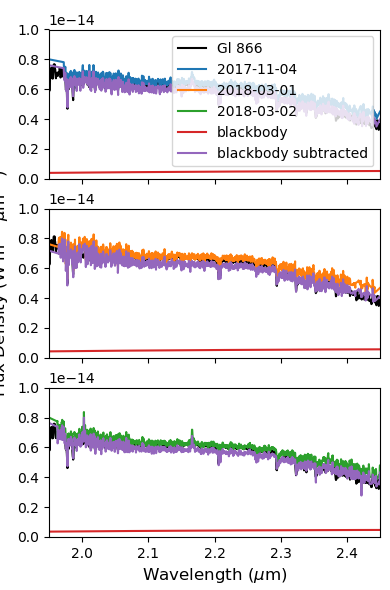

In [11]:
plt.figure(figsize=(6.,4.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
plt.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
plt.plot([0.,0.],[1.,1.])
plt.plot([0.,0.],[1.,1.])
plt.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
plt.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.95,2.45])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux density (W/m2/micron)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(6.,4.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
plt.plot([0.,0.],[1.,1.])
plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
plt.plot([0.,0.],[1.,1.])
plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.95,2.45])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux density (W/m2/micron)')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(6.,4.))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
plt.plot([0.,0.],[1.,1.])
plt.plot([0.,0.],[1.,1.])
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label='blackbody')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,1.0e-14])
plt.xlim([1.95,2.45])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux density (W/m2/micron)')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(3.9,5.9))
axarr[0].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-01')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-02')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
axarr[0].set_ylim([0.,1.0e-14])
axarr[0].set_xlim([1.95,2.45])
axarr[0].legend(loc='upper right')
#axarr[0].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=10)

axarr[1].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_blackbody, label='blackbody')
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
axarr[1].set_ylim([0.,1.0e-14])
axarr[1].set_xlim([1.95,2.45])
#axarr[1].xlabel('Wavelength (microns)')
#axarr[1].ylabel('Flux density (W/m2/micron)')
#axarr[1].legend(loc='upper right')
axarr[1].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)

axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/415.,'k',label='Gl 866')
axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
axarr[2].plot([0.,0.],[1.,1.])
axarr[2].plot([0.,0.],[1.,1.])
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label='blackbody')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
axarr[2].set_ylim([0.,1.0e-14])
axarr[2].set_xlim([1.95,2.45])
#plt.xlabel('Wavelength (microns)')
axarr[2].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)

f.subplots_adjust(hspace=0.2)
f.subplots_adjust(right=0.975)
f.subplots_adjust(top=0.95)
f.subplots_adjust(bottom=0.09)
#f.savefig('AWI0005x3s_full_highsnr_spectra.pdf')
f.show()



#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts - awi0005x3s_20171104_remerged_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/398.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_highsnr_wav, awi0005x3s_20171104_highsnr_flux_watts,label='2017-11-04')
#plt.plot(template_spectrum.short_wavelength, template_blackbody_trunclong_plotting)
#plt.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density/399.) + template_blackbody_trunclong_plotting)
#plt.ylim([0.,1.0e-14])
#plt.xlim([2.,2.5])
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts,label='AWI0005x3s')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged_blackbody)
#plt.ylim([1.0e-16,1.0e-13])
#plt.yscale('log',nonposy='clip')
#plt.show()

#plt.figure(figsize=(10.,6.))
#plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/399.,'k',label='Gl 866')
#plt.plot(awi0005x3s_20171104_remerged.wav, awi0005x3s_20171104_remerged.flux_watts - awi0005x3s_20171104_remerged_blackbody, label='AWI0005x3s blackbody subtracted')
#plt.ylim([0.,6.0e-14])
#plt.show()

<IPython.core.display.Javascript object>


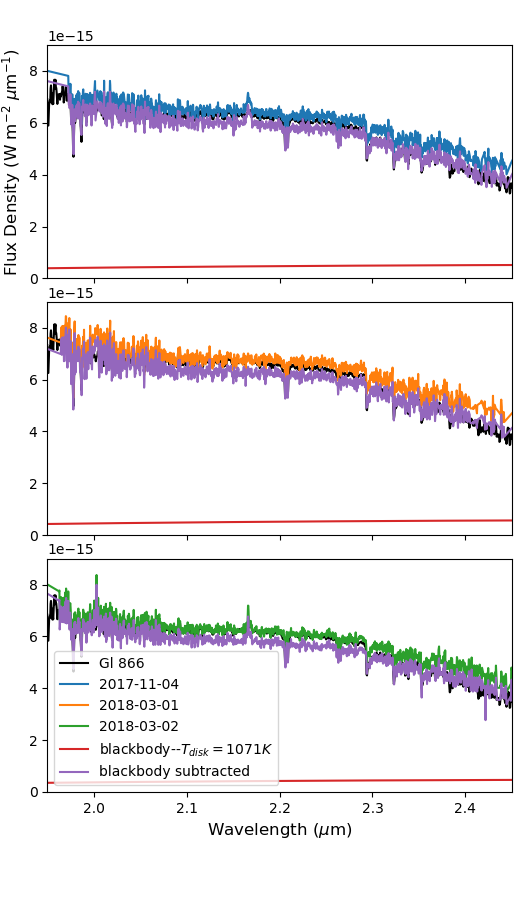

<IPython.core.display.Javascript object>


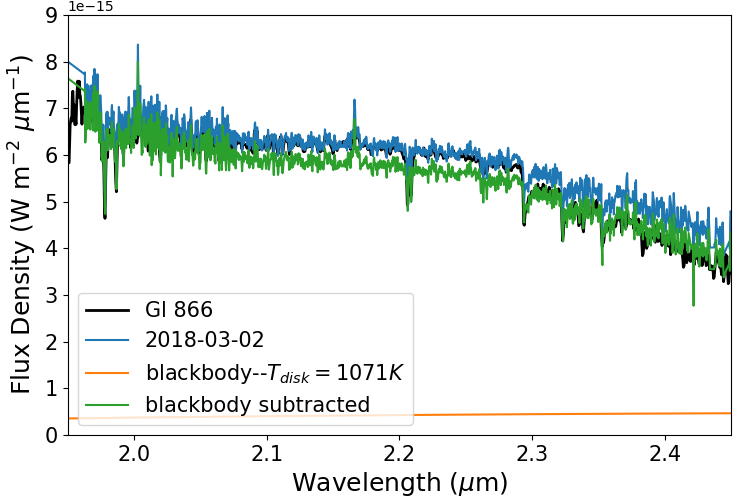

<IPython.core.display.Javascript object>


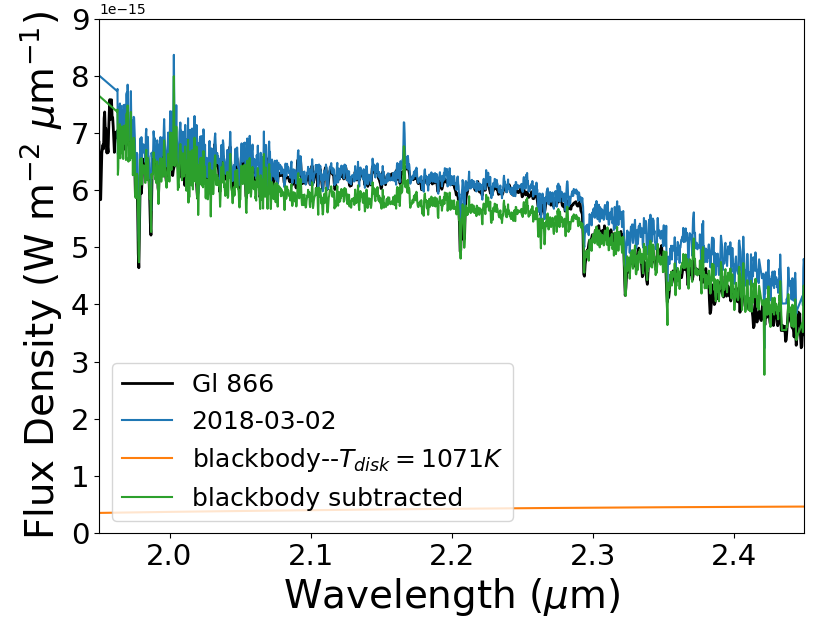

In [80]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(5.25,9))
axarr[0].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-01')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-02')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_merged_blackbody, label=r'blackbody--$T_{disk}= 1071 K')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
axarr[0].set_ylim([0.,9.0e-15])
axarr[0].set_xlim([1.95,2.45])
axarr[0].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
#axarr[0].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=10)

axarr[1].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_blackbody, label=r'blackbody--$T_{disk}= 1071 K')
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
axarr[1].set_ylim([0.,9.0e-15])
axarr[1].set_xlim([1.95,2.45])
#axarr[1].xlabel('Wavelength (microns)')
#axarr[1].ylabel('Flux density (W/m2/micron)')
#axarr[1].legend(loc='upper right')

#axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/415.,'k',label='Gl 866')
axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
axarr[2].plot([0.,0.],[1.,1.],label='2017-11-04')
axarr[2].plot([0.,0.],[1.,1.],label='2018-03-01')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label=r'blackbody--$T_{disk}= 1071 K$')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
axarr[2].set_ylim([0.,9.0e-15])
axarr[2].set_xlim([1.95,2.45])
axarr[2].legend(loc='lower left')
#plt.xlabel('Wavelength (microns)')
axarr[2].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)

f.subplots_adjust(hspace=0.1)
f.subplots_adjust(left=0.09)
f.subplots_adjust(right=0.975)
f.subplots_adjust(top=0.95)
f.subplots_adjust(bottom=0.12)
f.savefig('AWI0005x3s_Kband_highsnr_spectra.pdf')
#f.show()

plt.figure(figsize=(7.5,5))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',linewidth = 2, label='Gl 866')
#plt.plot([0.,0.],[1.,1.],label='2017-11-04')
#plt.plot([0.,0.],[1.,1.],label='2018-03-01')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label=r'blackbody--$T_{disk}= 1071 K$')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,9.0e-15])
plt.xlim([1.95,2.45])
plt.legend(loc='lower left',fontsize=15)
#plt.xlabel('Wavelength (microns)')
plt.xlabel(r'Wavelength ($\mu$m)', fontsize=18)
plt.ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.gcf().subplots_adjust(bottom=0.13)
plt.gcf().subplots_adjust(top=0.97)
plt.gcf().subplots_adjust(left=0.09)
plt.gcf().subplots_adjust(right=0.975)

#plt.show()
plt.savefig('excess_example_plot_for_presentation.png')

plt.figure(figsize=(8.25,6.2))
plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',linewidth = 2, label='Gl 866')
#plt.plot([0.,0.],[1.,1.],label='2017-11-04')
#plt.plot([0.,0.],[1.,1.],label='2018-03-01')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label=r'blackbody--$T_{disk}= 1071 K$')
plt.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
plt.ylim([0.,9.0e-15])
plt.xlim([1.95,2.45])
plt.legend(loc='lower left',fontsize=18)
#plt.xlabel('Wavelength (microns)')
plt.xlabel(r'Wavelength ($\mu$m)', fontsize=28)
plt.ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=28)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.gcf().subplots_adjust(bottom=0.14)
plt.gcf().subplots_adjust(top=0.97)
plt.gcf().subplots_adjust(left=0.12)
plt.gcf().subplots_adjust(right=0.975)

#plt.show()
plt.savefig('excess_example_plot_for_poster.png')

<IPython.core.display.Javascript object>


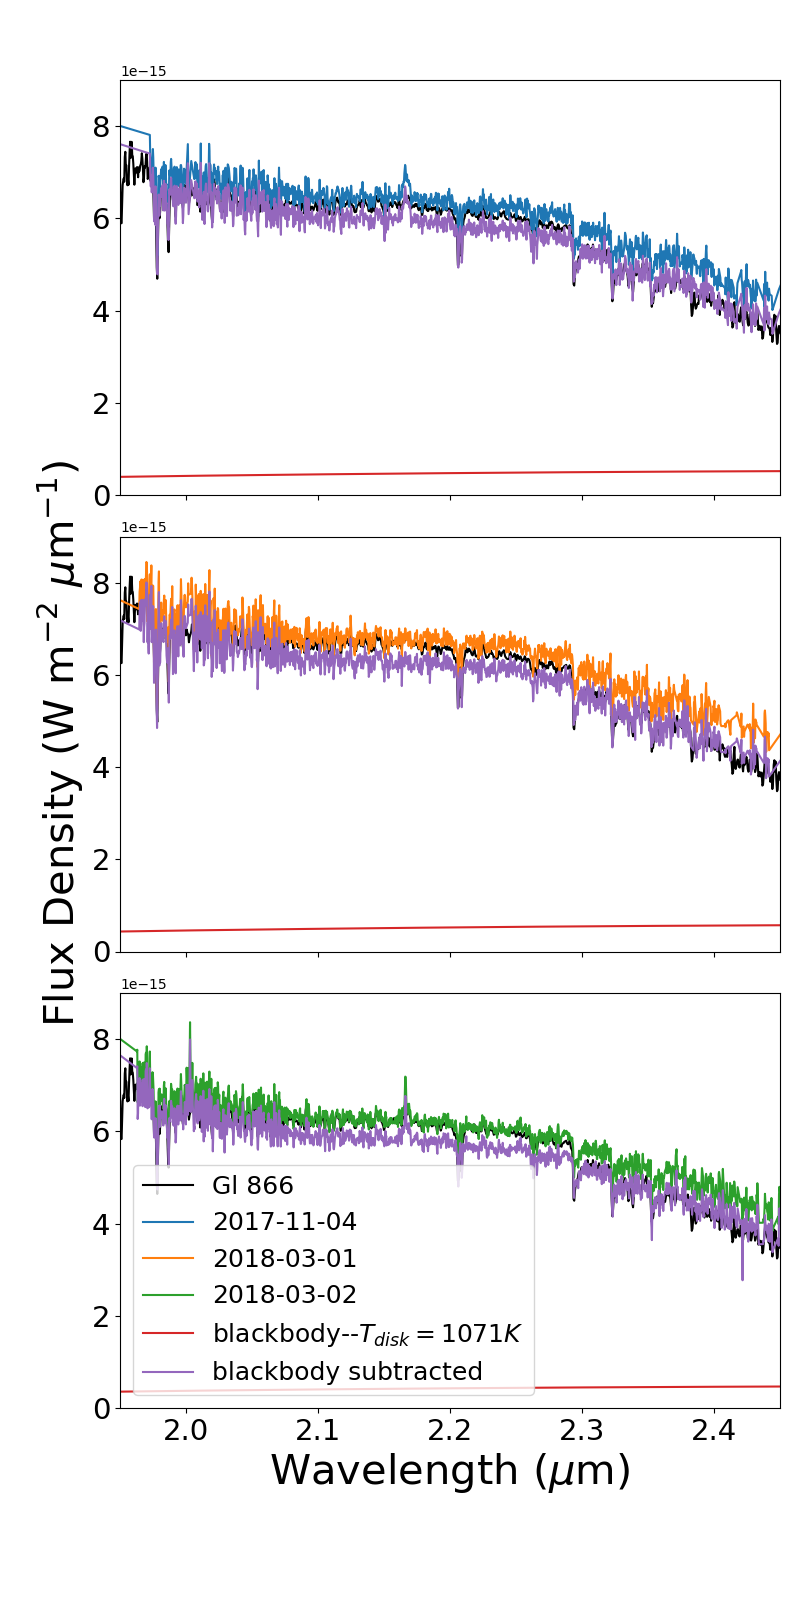

In [73]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(8,16))
axarr[0].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k',label='Gl 866')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts,label='2017-11-04')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-01')
axarr[0].plot([0.,0.],[1.,1.],label='2018-03-02')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_merged_blackbody, label=r'blackbody--$T_{disk}= 1071 K')
axarr[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts - awi0005x3s_20171104_2mass_merged_blackbody, label='blackbody subtracted')
axarr[0].set_ylim([0.,9.0e-15])
axarr[0].set_xlim([1.95,2.45])
axarr[1].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=30)
#axarr[0].set_ylabel(r'Flux Density (W m$^{-2}$ $\mu$m$^{-1}$)', fontsize=10)

axarr[1].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.0026,'k',label='Gl 866')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
axarr[1].plot([0.,0.],[1.,1.])
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_blackbody, label=r'blackbody--$T_{disk}= 1071 K')
axarr[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts - awi0005x3s_20180301_blackbody, label='blackbody subtracted')
axarr[1].set_ylim([0.,9.0e-15])
axarr[1].set_xlim([1.95,2.45])
#axarr[1].xlabel('Wavelength (microns)')
#axarr[1].ylabel('Flux density (W/m2/micron)')
#axarr[1].legend(loc='upper right')

#axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density/415.,'k',label='Gl 866')
axarr[2].plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.002425,'k',label='Gl 866')
axarr[2].plot([0.,0.],[1.,1.],label='2017-11-04')
axarr[2].plot([0.,0.],[1.,1.],label='2018-03-01')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts,label='2018-03-02')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_blackbody, label=r'blackbody--$T_{disk}= 1071 K$')
axarr[2].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts - awi0005x3s_20180302_blackbody, label='blackbody subtracted')
axarr[2].set_ylim([0.,9.0e-15])
axarr[2].set_xlim([1.95,2.45])
axarr[2].legend(loc='lower left',fontsize=18)
#plt.xlabel('Wavelength (microns)')
axarr[2].set_xlabel(r'Wavelength ($\mu$m)', fontsize=30)

axarr[0].xaxis.set_tick_params(labelsize=21)
axarr[0].yaxis.set_tick_params(labelsize=21)
axarr[1].xaxis.set_tick_params(labelsize=21)
axarr[1].yaxis.set_tick_params(labelsize=21)
axarr[2].xaxis.set_tick_params(labelsize=21)
axarr[2].yaxis.set_tick_params(labelsize=21)

f.subplots_adjust(hspace=0.1)
f.subplots_adjust(left=0.15)
f.subplots_adjust(right=0.975)
f.subplots_adjust(top=0.95)
f.subplots_adjust(bottom=0.12)
f.savefig('AWI0005x3s_Kband_highsnr_spectra_for_poster.png')
#f.show()


In [ ]:
fig, axarr1 = plt.subplots(1,2, figsize=(8,4))

pabeta_wav_use = 1.282 * (1.+(22.7/299792.458))
brgamma_wav_use = 2.166 * (1.+(22.7/299792.458))

axarr1[0].plot([pabeta_wav_use,pabeta_wav_use],[0.,1.],color='gray',linestyle='--')
axarr1[0].plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density*0.00245)-1.e-14,'k',label='Gl 866')
axarr1[0].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts-5.5e-15,label='2017-11-04')
axarr1[0].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts+1.e-15,label='2018-03-01')
axarr1[0].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts+(6.5e-15),label='2018-03-02')
axarr1[0].set_xlim([1.24, 1.32])
axarr1[0].set_ylim([0.,3.0e-14])
axarr1[0].set_ylabel(r'Relative Flux Density', fontsize=12)
axarr1[0].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)

axarr1[1].plot([brgamma_wav_use,brgamma_wav_use],[0.,1.],color='gray',linestyle='--')
axarr1[1].plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density*0.00245)-3.e-15,'k',label='Gl 866')
axarr1[1].plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts-1.5e-15,label='2017-11-04')
axarr1[1].plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts,label='2018-03-01')
axarr1[1].plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts+2.5e-15,label='2018-03-02')
axarr1[1].set_xlim([2.05, 2.25])
axarr1[1].set_ylim([0.,1.2e-14])

axarr1[1].legend(loc='lower left')
axarr1[1].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)
#axarr1[1].set_ylabel(r'Relative Flux Density', fontsize=12)


fig.subplots_adjust(hspace=0.12)
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(right=0.975)
#fig.subplots_adjust(top=0.975)
fig.subplots_adjust(bottom=0.17)

#fig.show()
fig.savefig('AWI0005x3s_accretion_lines.png')
fig.savefig('AWI0005x3s_accretion_lines.pdf')





<IPython.core.display.Javascript object>


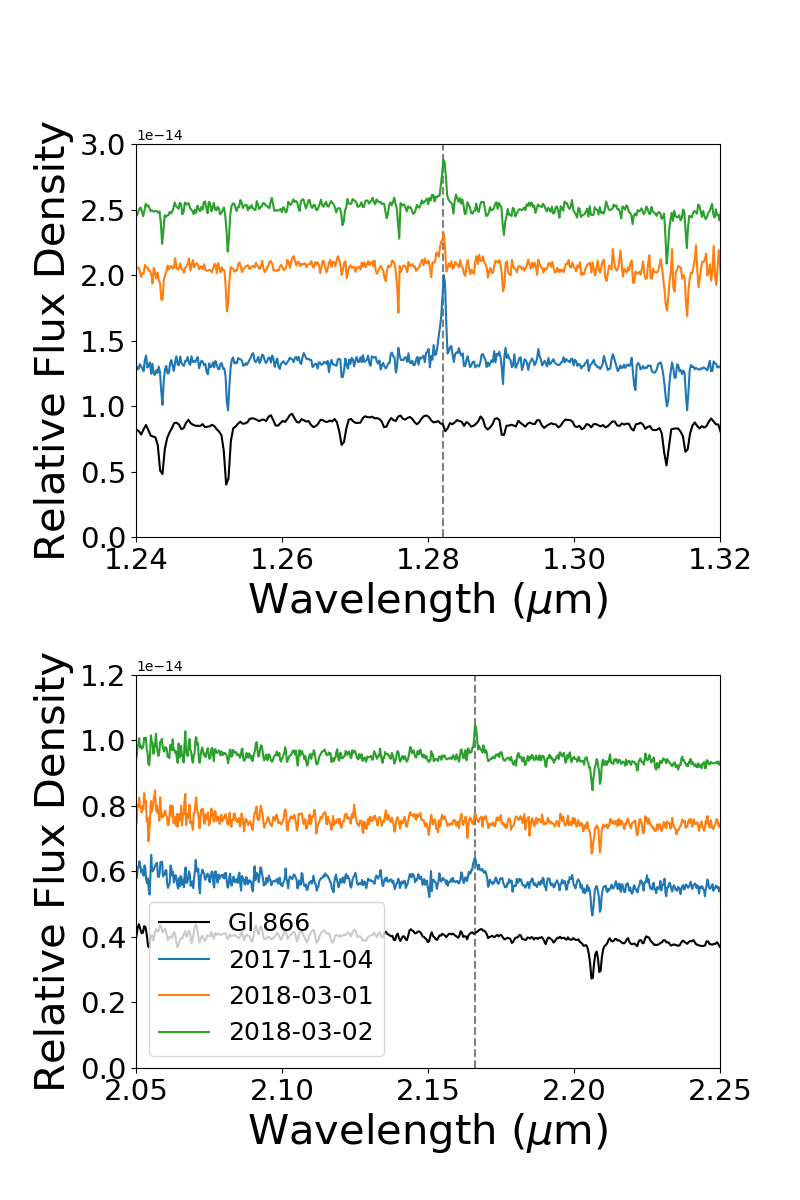

In [67]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))

pabeta_wav_use = 1.282 * (1.+(22.7/299792.458))
brgamma_wav_use = 2.166 * (1.+(22.7/299792.458))

ax1.plot([pabeta_wav_use,pabeta_wav_use],[0.,1.],color='gray',linestyle='--')
ax1.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density*0.00245)-1.e-14,'k',label='Gl 866')
ax1.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts-5.5e-15,label='2017-11-04')
ax1.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts+1.e-15,label='2018-03-01')
ax1.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts+(6.5e-15),label='2018-03-02')
ax1.set_xlim([1.24, 1.32])
ax1.set_ylim([0.,3.0e-14])
ax1.set_ylabel(r'Relative Flux Density', fontsize=30)
ax1.set_xlabel(r'Wavelength ($\mu$m)', fontsize=30)

ax2.plot([brgamma_wav_use,brgamma_wav_use],[0.,1.],color='gray',linestyle='--')
ax2.plot(template_spectrum.short_wavelength, (template_spectrum.short_flux_density*0.00245)-3.e-15+7.5e-16,'k',label='Gl 866')
ax2.plot(awi0005x3s_20171104_2mass_highsnr.wav, awi0005x3s_20171104_2mass_highsnr.flux_watts-1.5e-15+7.5e-16,label='2017-11-04')
ax2.plot(awi0005x3s_20180301_highsnr.wav, awi0005x3s_20180301_highsnr.flux_watts+7.5e-16,label='2018-03-01')
ax2.plot(awi0005x3s_20180302_highsnr.wav, awi0005x3s_20180302_highsnr.flux_watts+2.5e-15+7.5e-16,label='2018-03-02')
ax2.set_xlim([2.05, 2.25])
ax2.set_ylim([0.,1.2e-14])

ax2.legend(loc='lower left',fontsize=18)
ax2.set_ylabel(r'Relative Flux Density', fontsize=30)
ax2.set_xlabel(r'Wavelength ($\mu$m)', fontsize=30)
#axarr1[1].set_ylabel(r'Relative Flux Density', fontsize=12)


ax1.xaxis.set_tick_params(labelsize=21)
ax1.yaxis.set_tick_params(labelsize=21)
ax2.xaxis.set_tick_params(labelsize=21)
ax2.yaxis.set_tick_params(labelsize=21)
#ax2.tickparams(fontsize=18)

#axarr1[1].set_xticklabels(xticklabels, fontsize=18)
#axarr1[1].set_ytickparams(fontsize=18)
fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(left=0.17)
#fig.subplots_adjust(right=0.975)
#fig.subplots_adjust(top=0.975)
#fig.subplots_adjust(bottom=0.17)

#fig.show()
fig.savefig('AWI0005x3s_accretion_lines_for_poster.png')
#fig.savefig('AWI0005x3s_accretion_lines.pdf')





The code you were looking for!

Important caveat: my observed line profiles are such that direct integration was a better technique than Gaussian fitting. YMMV.

This function takes your target spectrum, and the flux vector from your continuum vector. It defines continuum windows on either side of the Pa $\beta$ line, and gets the flux and error in those windows, as well as the continuum spectrum values.

I determined the SNR by measuring the error-weighted RMS difference between the observed spectrum and the continuum spectrum at each wavelength. I defined the SNR as the average continuum value in the region, divided by this RMS (similar calculation to what IRAF does in splot, though I added the error-weighting).

I then defined a window for the line, and extracted the wavelengths, observed flux, and continuum-spectrum flux in that region. I converted the wavelength to angstroms to get the eq. widths. I then divided the line flux by the continuum spectrum flux, and integrated (1-(lineflux/contflux)) over the wavelength window (in angstroms) to get the equivalent width. Following Wisniewski et al. (2003) (http://adsabs.harvard.edu/abs/2003ApJ...588..486W), I determined the eq. width uncertainty based on the SNR, width of the line in pixel space, blaze function, and average value of (line/cont) across the line (see references therein for more detail on this calculation).

I determined the average value of the underlying continuum (in $\mathrm{W m^{-2} \mu m^{-1}}$) by integrating the continuum spectrum over the wavelength window, and then dividing by the window (with uncertainty based on the SNR). I then recover the line flux (with associated uncertainty) by multiply the average continuum by the equivalent width (with normal uncertainty propagation).

In [ ]:
def get_Pabeta_flux(target_spectrum, continuum_flux_use):
    print r'Pa $\beta$'
    pabeta_cont_x = np.array([x for x in target_spectrum.wav if ((x > 1.2565 and x <1.2665) or (x>1.2925 and x<1.31))])
    pabeta_cont_flux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>1.2565 and target_spectrum.wav[i]<1.2665) or (target_spectrum.wav[i]>1.2925 and target_spectrum.wav[i]<1.31))])
    pabeta_cont_err = np.array([target_spectrum.err_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>1.2565 and target_spectrum.wav[i]<1.2665) or (target_spectrum.wav[i]>1.2925 and target_spectrum.wav[i]<1.31))])
    pabeta_continuum_vals_cont = np.interp(pabeta_cont_x,target_spectrum.wav,continuum_flux_use)
    
    difs_continuum_pabeta = pabeta_continuum_vals_cont - pabeta_cont_flux
    difs_continuum_square_pabeta = difs_continuum_pabeta**2
    avg_difs_continuum_square_errweight_pabeta = np.sum(difs_continuum_square_pabeta*(1/(pabeta_cont_err**2)))/np.sum(1/(pabeta_cont_err**2))
    rms_continuum_errweight_pabeta = avg_difs_continuum_square_errweight_pabeta ** 0.5
    snr_continuum_errweight_pabeta = (np.sum(pabeta_continuum_vals_cont)/float(pabeta_continuum_vals_cont.size))/rms_continuum_errweight_pabeta

    print np.sum(pabeta_continuum_vals_cont)/float(pabeta_continuum_vals_cont.size)
    print rms_continuum_errweight_pabeta
    print snr_continuum_errweight_pabeta
    
    
    pabeta_linewav = np.array([x for x in target_spectrum.wav if ((x > 1.278) and (x<1.2865))])
    pabeta_lineflux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in pabeta_linewav)])
    pabeta_linecont = np.array([continuum_flux_use[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in pabeta_linewav)])

    pabeta_linewav_angstroms = pabeta_linewav * 10000.
    
    
    pabeta_linecont_ratio = pabeta_lineflux/pabeta_linecont

    pabeta_eqwidth_angstroms = np.trapz((1.-pabeta_linecont_ratio),x=pabeta_linewav_angstroms)
    #awi0005x3s_20171104_brgamma_eqwidth_angstroms = awi0005x3s_20171104_brgamma_eqwidth*10000.

    #print "eq width (angstroms):", pabeta_eqwidth_angstroms
    #print "log(eq width (angstroms)):",np.log10(-pabeta_eqwidth_angstroms)
    #print "pixels",pabeta_linecont_ratio.size
    #print "wavespace:",pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0]
    #print "h_lambda:",(pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0])/float(pabeta_linecont_ratio.size)

    hlambda_pabeta = (pabeta_linewav_angstroms[-1] - pabeta_linewav_angstroms[0])/float(pabeta_linecont_ratio.size)

    fstar_fc_pabeta = np.sum(pabeta_linecont_ratio)/float(pabeta_linecont_ratio.size)
    print 'f*/fc',fstar_fc_pabeta

    pabeta_eqwidth_unc_angstroms = np.sqrt(float(pabeta_linecont_ratio.size)*((hlambda_pabeta/snr_continuum_errweight_pabeta)**2)*fstar_fc_pabeta)

    #print "unc. eq width (angstroms):",pabeta_eqwidth_unc_angstroms
    #print "fractional uncertainty:",pabeta_eqwidth_unc_angstroms/abs(pabeta_eqwidth_angstroms)

    pabeta_linecont_avg = np.trapz(pabeta_linecont,x=pabeta_linewav)/(pabeta_linewav[-1]-pabeta_linewav[0])
    pabeta_linecont_avg_unc = pabeta_linecont_avg/snr_continuum_errweight_pabeta

    #print "continuum level:",pabeta_linecont_avg, pabeta_linecont_avg_unc
    #print "fractional uncertainty:",pabeta_linecont_avg_unc/pabeta_linecont_avg


    pabeta_lineflux = pabeta_linecont_avg * pabeta_eqwidth_angstroms/10000.*-1.
    pabeta_lineflux_unc = ((((pabeta_eqwidth_unc_angstroms/abs(pabeta_eqwidth_angstroms))**2) + ((pabeta_linecont_avg_unc/pabeta_linecont_avg)**2))**0.5)*pabeta_lineflux
    #print 'line flux (W/m2):',pabeta_lineflux, pabeta_lineflux_unc

    pabeta_lineflux_cgs = pabeta_lineflux * 1000. 
    pabeta_lineflux_unc_cgs = pabeta_lineflux_unc * 1000.
    #print 'line flux (erg/s/cm2):',pabeta_lineflux_cgs, pabeta_lineflux_unc_cgs

    #print np.log10(pabeta_lineflux_cgs)
    print ''

    return pabeta_eqwidth_angstroms, pabeta_eqwidth_unc_angstroms, pabeta_lineflux, pabeta_lineflux_unc

Everything I said above, but applied to Br $\gamma$.

In [ ]:
def get_Brgamma_flux(target_spectrum, continuum_flux_use):
    print r'Br $\gamma$'
    #Get observed continuum ranges and IRAF continuum values for determining SNR
    brgamma_cont_x = np.array([x for x in target_spectrum.wav if ((x > 2.135 and x <2.155) or (x>2.175 and x<2.1925))])
    brgamma_cont_flux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>2.135 and target_spectrum.wav[i]<2.155) or (target_spectrum.wav[i]>2.175 and target_spectrum.wav[i]<2.1925))])
    brgamma_cont_err = np.array([target_spectrum.err_watts[i] for i in range(target_spectrum.wav.size) if ((target_spectrum.wav[i]>2.135 and target_spectrum.wav[i]<2.155) or (target_spectrum.wav[i]>2.175 and target_spectrum.wav[i]<2.1925))])
    brgamma_continuum_vals_cont = np.interp(brgamma_cont_x,target_spectrum.wav,continuum_flux_use)
    
    #plt.figure()
    #plt.errorbar(brgamma_cont_x, brgamma_cont_flux, yerr=brgamma_cont_err)
    #plt.plot(brgamma_cont_x, brgamma_continuum_vals_cont)
    #plt.show()
    
    #Calculate SNR
    difs_continuum_brgamma = brgamma_continuum_vals_cont - brgamma_cont_flux #Difference at each point between IRAF and observed
    difs_continuum_square_brgamma = difs_continuum_brgamma**2 #Squared difference
    avg_difs_continuum_square_errweight_brgamma = np.sum(difs_continuum_square_brgamma*(1/(brgamma_cont_err**2)))/np.sum(1/(brgamma_cont_err**2)) #Error-weighted average of squared differences
    rms_continuum_errweight_brgamma = avg_difs_continuum_square_errweight_brgamma ** 0.5 #RMS of error-weighted differences
    snr_continuum_errweight_brgamma = (np.sum(brgamma_continuum_vals_cont)/float(brgamma_continuum_vals_cont.size))/rms_continuum_errweight_brgamma #SNR--average continuum/error-weighted RMS

    print np.sum(brgamma_continuum_vals_cont)/float(brgamma_continuum_vals_cont.size) #Average continuum
    print rms_continuum_errweight_brgamma #RMS
    print snr_continuum_errweight_brgamma #SNR
    
    #Get in-line wavelength, flux, continuum
    brgamma_linewav = np.array([x for x in target_spectrum.wav if ((x > 2.162) and (x<2.171))])
    brgamma_lineflux = np.array([target_spectrum.flux_watts[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in brgamma_linewav)])
    brgamma_linecont = np.array([continuum_flux_use[i] for i in range(target_spectrum.wav.size) if (target_spectrum.wav[i] in brgamma_linewav)])

    brgamma_linewav_angstroms = brgamma_linewav * 10000. #In angstroms
    
    #plt.figure()
    #plt.plot(brgamma_linewav, brgamma_lineflux)
    #plt.plot(brgamma_linewav, brgamma_linecont)
    #plt.show()
    
    brgamma_linecont_ratio = brgamma_lineflux/brgamma_linecont #Line/continuum

    brgamma_eqwidth_angstroms = np.trapz((1.-brgamma_linecont_ratio),x=brgamma_linewav_angstroms) #Eq. width

    #print "eq width (angstroms):", brgamma_eqwidth_angstroms
    #print "log(eq width (angstroms)):",np.log10(-brgamma_eqwidth_angstroms)
    #print "pixels",brgamma_linecont_ratio.size
    #print "wavespace:",brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0]
    #print "h_lambda:",(brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0])/float(brgamma_linecont_ratio.size)

    hlambda_brgamma = (brgamma_linewav_angstroms[-1] - brgamma_linewav_angstroms[0])/float(brgamma_linecont_ratio.size)

    fstar_fc_brgamma = np.sum(brgamma_linecont_ratio)/float(brgamma_linecont_ratio.size)
    print 'f*/fc',fstar_fc_brgamma

    brgamma_eqwidth_unc_angstroms = np.sqrt(float(brgamma_linecont_ratio.size)*((hlambda_brgamma/snr_continuum_errweight_brgamma)**2)*fstar_fc_brgamma)

    #print "unc. eq width (angstroms):",brgamma_eqwidth_unc_angstroms
    #print "fractional uncertainty:",brgamma_eqwidth_unc_angstroms/abs(brgamma_eqwidth_angstroms)

    brgamma_linecont_avg = np.trapz(brgamma_linecont,x=brgamma_linewav)/(brgamma_linewav[-1]-brgamma_linewav[0])
    brgamma_linecont_avg_unc = brgamma_linecont_avg/snr_continuum_errweight_brgamma

    #print "continuum level:",brgamma_linecont_avg, brgamma_linecont_avg_unc
    #print "fractional uncertainty:",brgamma_linecont_avg_unc/brgamma_linecont_avg


    brgamma_lineflux = brgamma_linecont_avg * brgamma_eqwidth_angstroms/10000.*-1.
    brgamma_lineflux_unc = ((((brgamma_eqwidth_unc_angstroms/abs(brgamma_eqwidth_angstroms))**2) + ((brgamma_linecont_avg_unc/brgamma_linecont_avg)**2))**0.5)*brgamma_lineflux
    #print 'line flux (W/m2):',brgamma_lineflux, brgamma_lineflux_unc

    brgamma_lineflux_cgs = brgamma_lineflux * 1000. 
    brgamma_lineflux_unc_cgs = brgamma_lineflux_unc * 1000.
    #print 'line flux (erg/s/cm2):',brgamma_lineflux_cgs, brgamma_lineflux_unc_cgs

    #print np.log10(brgamma_lineflux_cgs)
    print ''

    return brgamma_eqwidth_angstroms, brgamma_eqwidth_unc_angstroms, brgamma_lineflux, brgamma_lineflux_unc

Converting from line fluxes to line luminosities (thanks to Gaia DR2), and putting that in units of $\log L_{\mathrm{acc}}/L_{\odot}$.

In [ ]:
def get_pabeta_luminosity(target_spectrum, distance, distance_unc):
    pabeta_luminosity_watts = target_spectrum.pabeta_lineflux * 4. * np.pi * (distance**2)
    pabeta_luminosity_unc_watts = 4. * np.pi * distance * ((((4.*(target_spectrum.pabeta_lineflux**2))*(distance_unc**2)) + ((distance**2)*(target_spectrum.pabeta_lineflux_unc**2)))**0.5)
    
    pabeta_luminosity_Lsol = pabeta_luminosity_watts / (3.828e26)
    pabeta_luminosity_unc_Lsol = pabeta_luminosity_unc_watts / (3.828e26)
    
    log_pabeta_luminosity_Lsol = np.log10(pabeta_luminosity_Lsol)
    log_pabeta_luminosity_unc_Lsol = (1/np.log(10.))*(pabeta_luminosity_unc_Lsol/pabeta_luminosity_Lsol)
    
    print log_pabeta_luminosity_Lsol, log_pabeta_luminosity_unc_Lsol
    
    return pabeta_luminosity_Lsol, pabeta_luminosity_unc_Lsol, log_pabeta_luminosity_Lsol, log_pabeta_luminosity_unc_Lsol


def get_brgamma_luminosity(target_spectrum, distance, distance_unc):
    brgamma_luminosity_watts = target_spectrum.brgamma_lineflux * 4. * np.pi * (distance**2)
    brgamma_luminosity_unc_watts = 4. * np.pi * distance * ((((4.*(target_spectrum.brgamma_lineflux**2))*(distance_unc**2)) + ((distance**2)*(target_spectrum.brgamma_lineflux_unc**2)))**0.5)
    
    brgamma_luminosity_Lsol = brgamma_luminosity_watts / (3.828e26)
    brgamma_luminosity_unc_Lsol = brgamma_luminosity_unc_watts / (3.828e26)
    
    log_brgamma_luminosity_Lsol = np.log10(brgamma_luminosity_Lsol)
    log_brgamma_luminosity_unc_Lsol = (1/np.log(10.))*(brgamma_luminosity_unc_Lsol/brgamma_luminosity_Lsol)
    
    print log_brgamma_luminosity_Lsol, log_brgamma_luminosity_unc_Lsol
    
    return brgamma_luminosity_Lsol, brgamma_luminosity_unc_Lsol, log_brgamma_luminosity_Lsol, log_brgamma_luminosity_unc_Lsol

In [ ]:
def get_accretion_luminosity_pabeta(target_spectrum):
    x = target_spectrum.log_pabeta_luminosity
    delx = target_spectrum.log_pabeta_luminosity_unc
    
    m = 1.14
    delm = 0.16
    
    b = 3.15
    delb = 0.58
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

Convert from Pa $\beta$ luminosity to accretion luminosity, following the relation from Natta et al. (2004) (http://adsabs.harvard.edu/abs/2004A%26A...424..603N). I used this relation instead of the similar relation in Muzerolle et al. (1998c) because this one incorporates objects at lower mass than my target, allowing me to interpolate. Annoyingly, the error bars end up being huge ($>1$ dex) due to having to multiply the square uncertainty in the slope by the square observed log(luminosity) when adding the uncertainties.

In [ ]:
def get_accretion_luminosity_pabeta_test(target_spectrum):
    x = target_spectrum.log_pabeta_luminosity
    delx = target_spectrum.log_pabeta_luminosity_unc
    
    m = 1.36
    delm = 0.2
    
    b = 4.00
    delb = 0.2
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

Convert from Br $\gamma$ luminosity to accretion luminosity using the Muzerolle et al. (1998c) (http://adsabs.harvard.edu/abs/1998AJ....116.2965M) relation. Same issue with uncertainties here.

In [ ]:
def get_accretion_luminosity_brgamma(target_spectrum):
    x = target_spectrum.log_brgamma_luminosity
    delx = target_spectrum.log_brgamma_luminosity_unc
    
    m = 1.26
    delm = 0.19
    
    b = 4.43
    delb = 0.79
    
    log_Lacc_Lsol = m*x + b
    
    log_Lacc_Lsol_unc = (((m**2)*(delx**2)) + ((x**2)*(delm**2)) + (delb**2))**0.5
    
    return log_Lacc_Lsol, log_Lacc_Lsol_unc

Get error-weighted average accretion luminosity, with associated uncertainty.

In [ ]:
def get_final_accretion_luminosity(target_spectrum):
    a1 = target_spectrum.log_accretion_luminosity_pabeta
    da1 = target_spectrum.log_accretion_luminosity_pabeta_unc
    
    a2 = target_spectrum.log_accretion_luminosity_brgamma
    da2 = target_spectrum.log_accretion_luminosity_brgamma_unc

    weight1 = 1./(da1**2)
    weight2 = 1./(da2**2)
    
    weighted_average_num = (weight1*a1) + (weight2*a2)
    weighted_average_den = weight1 + weight2
    
    weighted_average = weighted_average_num/weighted_average_den
    weighted_average_unc = 1./(((weight1**2)+(weight2**2))**0.5)
    
    return weighted_average, weighted_average_unc

The function that calls all the previous functions.

Input: target_spectrum, continuum_spectrum, parallax, parallax_error

Steps:
1: Convert from parallax to distance in parsecs...then to distance in meters
2: Get the continuum spectrum in the correct format. If the continuum spectrum is a normalized spectrum, divide the observed spectrum by the normalized spectrum to get the continuum spectrum. If it's the fit spectrum, multiply by 10 to put it on the correct flux units.
3: Get line fluxes (stored in the target_spectrum object).
4: Get line luminosities (stored in the target_spectrum object).
5: Get accretion luminosities (stored in the target_spectrum object).

In [ ]:
def get_accretion_luminosities(target_spectrum, continuum_spectrum, parallax, parallax_error):
    distance_parsec = 1000./parallax
    distance_unc_parsec = (parallax_error/parallax) * distance_parsec
    
    distance_meters = distance_parsec * 3.08567758149137e16
    distance_unc_meters = distance_unc_parsec * 3.08567758149137e16
    
    if continuum_spectrum.is_normalized:
        continuum_flux_interp = np.interp(target_spectrum.wav, continuum_spectrum.wavelength, continuum_spectrum.flux_density)
        continuum_flux_use = target_spectrum.flux_watts / continuum_flux_interp
    else:
        continuum_flux_use = np.interp(target_spectrum.wav, continuum_spectrum.wavelength, continuum_spectrum.flux_density) * 10.
    
    target_spectrum.pabeta_eqwidth_angstroms, target_spectrum.pabeta_eqwidth_unc_angstroms, target_spectrum.pabeta_lineflux, target_spectrum.pabeta_lineflux_unc =  get_Pabeta_flux(target_spectrum, continuum_flux_use)
    
    target_spectrum.brgamma_eqwidth_angstroms, target_spectrum.brgamma_eqwidth_unc_angstroms, target_spectrum.brgamma_lineflux, target_spectrum.brgamma_lineflux_unc =  get_Brgamma_flux(target_spectrum, continuum_flux_use)
    
    target_spectrum.pabeta_luminosity, target_spectrum.pabeta_luminosity_unc, target_spectrum.log_pabeta_luminosity, target_spectrum.log_pabeta_luminosity_unc = get_pabeta_luminosity(target_spectrum, distance_meters, distance_unc_meters)
    target_spectrum.brgamma_luminosity, target_spectrum.brgamma_luminosity_unc, target_spectrum.log_brgamma_luminosity, target_spectrum.log_brgamma_luminosity_unc = get_brgamma_luminosity(target_spectrum, distance_meters, distance_unc_meters)
    
    target_spectrum.log_accretion_luminosity_pabeta, target_spectrum.log_accretion_luminosity_pabeta_unc = get_accretion_luminosity_pabeta_test(target_spectrum)
    target_spectrum.log_accretion_luminosity_brgamma, target_spectrum.log_accretion_luminosity_brgamma_unc = get_accretion_luminosity_brgamma(target_spectrum)
    
    print target_spectrum.brgamma_luminosity, target_spectrum.brgamma_luminosity_unc*5.
    if target_spectrum.brgamma_luminosity < 5.*target_spectrum.brgamma_luminosity_unc:
        target_spectrum.log_accretion_luminosity = target_spectrum.log_accretion_luminosity_pabeta
        target_spectrum.log_accretion_luminosity_unc = target_spectrum.log_accretion_luminosity_pabeta_unc
    else:
        target_spectrum.log_accretion_luminosity, target_spectrum.log_accretion_luminosity_unc = get_final_accretion_luminosity(target_spectrum)
    
    #target_spectrum.log_accretion_luminosity = ((target_spectrum.log_accretion_luminosity_pabeta/(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (target_spectrum.log_accretion_luminosity_brgamma/(target_spectrum.log_accretion_luminosity_brgamma_unc**2))/((1./(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (1./(target_spectrum.log_accretion_luminosity_brgamma_unc**2))))
    #target_spectrum.log_accretion_luminosity_unc = ((1./(target_spectrum.log_accretion_luminosity_pabeta_unc**2)) + (1./(target_spectrum.log_accretion_luminosity_brgamma_unc**2)))**0.5
    
    print r'Pa $\beta$:'
    print 'Eq. Width:', target_spectrum.pabeta_eqwidth_angstroms, target_spectrum.pabeta_eqwidth_unc_angstroms
    print 'Line flux:', target_spectrum.pabeta_lineflux, target_spectrum.pabeta_lineflux_unc
    print r'log$_{10}$ L_line/Lsol:', target_spectrum.log_pabeta_luminosity, target_spectrum.log_pabeta_luminosity_unc
    print r'log$_{10}$ Lacc/Lsol:', target_spectrum.log_accretion_luminosity_pabeta, target_spectrum.log_accretion_luminosity_pabeta_unc
    print ''
    
    print r'Br $\gamma$:'
    print 'Eq. Width:', target_spectrum.brgamma_eqwidth_angstroms, target_spectrum.brgamma_eqwidth_unc_angstroms
    print 'Line flux:', target_spectrum.brgamma_lineflux, target_spectrum.brgamma_lineflux_unc
    print r'log$_{10}$ L_line/Lsol:', target_spectrum.log_brgamma_luminosity, target_spectrum.log_brgamma_luminosity_unc
    print r'log$_{10}$ Lacc/Lsol:', target_spectrum.log_accretion_luminosity_brgamma, target_spectrum.log_accretion_luminosity_brgamma_unc
    print ''
    
    print 'Accretion luminosity:', target_spectrum.log_accretion_luminosity, target_spectrum.log_accretion_luminosity_unc
    print ''
    
    #test_pabeta_accretion_luminosity, test_pabeta_accretion_luminosity_unc = get_accretion_luminosity_pabeta_test(target_spectrum)
    #print test_pabeta_accretion_luminosity, test_pabeta_accretion_luminosity_unc
    
    return

In [ ]:
awi0005x3s_xtc_20180301_remerged_con = import_continuum_spectrum_from_file('awi0005x3s_xtc_20180301_remerged_IRAF_con.txt',False)
awi0005x3s_xtc_20180302_remerged_con = import_continuum_spectrum_from_file('awi0005x3s_xtc_20180302_remerged_IRAF_con.txt',False)

In [ ]:
print 'AWI0005x3s, 2017-11-04'
get_accretion_luminosities(awi0005x3s_20171104_2mass_highsnr, awi0005x3s_xtc_20171104_2massweighted_normalized, 9.8599, 0.0551)
print ''

print 'AWI0005x3s, 2018-03-01'
get_accretion_luminosities(awi0005x3s_20180301_highsnr,awi0005x3s_xtc_20180301_remerged_con, 9.8599, 0.0551)
print ''

print 'AWI0005x3s, 2018-03-02'
get_accretion_luminosities(awi0005x3s_20180302_highsnr,awi0005x3s_xtc_20180302_remerged_con, 9.8599, 0.0551)
print ''

Convert accretion luminosity to mass accretion rate, based on the function $L_{\mathrm{acc}} \approx \frac{G M_{\star}\dot(M)}{R_{\star}} (1 - \frac{R_{\star}}{r_{in}})$, where $r_{in}$ is the inner radius of the accretion disk.

I started by finding the value of $\dot{M}$ when $L_{\mathrm{acc}} = 1 L_{\odot}$, $M_{\star} = 1 M_{\odot}$, and $R_{\star} = 1 R_{\odot}$, to get a base value $\dot{M}_{0}$. This lets you calculate $\dot{M} = \dot{M}_{0} \frac{L_{\mathrm{acc}}}{L_{\odot}} \frac{R_{\star}}{R_{\odot}} \frac{M_{\odot}}{M_{\star}}$.

I adopted the blackbody radius of the hot disk for my system as the inner accretion disk radius, and calculated everything in log-space (because addition is easier than multiplication).

In [ ]:
Lsol = 3.828e26
GMsol = 132712440000000000000.
Rsol = 695700000.

GMsol_Rsol = GMsol/Rsol

Mdot_sol_SI = Lsol/GMsol_Rsol

Mdot_sol = Mdot_sol_SI / 1.98847541533814e30 * (365.25*24.*60.*60.)
log_Mdot_sol = np.log10(Mdot_sol)

def get_mass_accretion_rate(target_spectrum, mstar, mstar_unc, rstar, rstar_unc, rin, rin_unc):
    rin_rstar = 1./rin
    rin_rstar_use = 1. - rin_rstar
    
    rin_rstar_unc = (rin_unc/rin) * rin_rstar
    
    logmstar = np.log10(mstar)
    logmstar_unc = (1./np.log(10.))*(mstar_unc/mstar)
    
    logrstar = np.log10(rstar)
    logrstar_unc = (1./np.log(10.))*(rstar_unc/rstar)
    
    logrin = np.log10(rin_rstar_use)
    logrin_unc = (1./np.log(10.))*(rin_rstar_unc/rin_rstar_use)
    
    target_spectrum.logMdot = logrin + log_Mdot_sol + target_spectrum.log_accretion_luminosity + logrstar - logmstar
    target_spectrum.logMdot_unc = ((logrin_unc**2) + (target_spectrum.log_accretion_luminosity_unc**2) + (logmstar_unc**2) + (logrstar_unc**2))
    
    print target_spectrum.logMdot, target_spectrum.logMdot_unc
    
    return

In [ ]:
print 'AWI0005x3s, 2017-11-04'
get_mass_accretion_rate(awi0005x3s_20171104_2mass_highsnr, 0.16, 0.04, 0.30, 0.04, 4.073, 0.688)
print ''

print 'AWI0005x3s, 2018-03-01'
get_mass_accretion_rate(awi0005x3s_20180301_highsnr, 0.16, 0.04, 0.30, 0.04, 4.073, 0.688)
print ''

print 'AWI0005x3s, 2018-03-02'
get_mass_accretion_rate(awi0005x3s_20180302_highsnr, 0.16, 0.04, 0.30, 0.04, 4.073, 0.688)
print ''